In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit



ro=8.
#paper on MC used R0=8.5 kpc, using ro=8. as of now.
vo=220.

/home/nil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Populating the interactive namespace from numpy and matplotlib


In [22]:
hdulist=fits.open('molecular_clouds/J_ApJ_834_57_table1.dat.gz.fits')
print (hdulist[1].columns)
aa=hdulist[1].data

ColDefs(
    name = 'Cloud'; format = 'I4'; disp = 'I4'; start = 1
    name = 'Ncomp'; format = 'I3'; disp = 'I3'; start = 6
    name = 'Npix'; format = 'I3'; disp = 'I3'; start = 10
    name = 'Area'; format = 'E12.6'; unit = 'deg2'; disp = 'E12.6'; start = 14
    name = 'GLON'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 27
    name = 'Sigb'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 41
    name = 'GLAT'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 54
    name = 'Sigl'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 68
    name = 'theta'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 81
    name = 'WCO'; format = 'E12.6'; unit = 'K.km/s'; disp = 'E12.6'; start = 95
    name = 'NH2'; format = 'E12.6'; unit = 'cm-2'; disp = 'E12.6'; start = 108
    name = 'Sigma'; format = 'E12.6'; unit = 'Msun/pc2'; disp = 'E12.6'; start = 121
    name = 'Vcent'; format = 'E13.6'; unit = 'km/s'; disp = 'E13.6'; start = 134
    name = 'SigV'; for

#To setup the orbits of the MCs, take (l,b,d) --> galactocentric rectangular coordinates

[R,vR,vT(,z,vz,phi)]

In [23]:
l=aa['GLON']
b=aa['GLAT']
#Near or far distance flag (0=near; 1=far) 
flag=aa['INF']
Dnear=aa['Dnear']
Dfar=aa['Dfar']
znear=aa['znear']
zfar=aa['zfar']
R_sph_gal=aa['Rgal']
Rnear=aa['Rnear']
Rfar=aa['Rfar']
Mnear=aa['Mnear']
Mfar=aa['Mfar']

In [24]:
def lbd_to_galcencyl(l,b,d,degree=True):
    xyz=bovy_coords.lbd_to_XYZ(l,b,d,degree=degree)
    Rphiz=bovy_coords.XYZ_to_galcencyl(xyz[:,0],xyz[:,1],xyz[:,2],Xsun=1.,Zsun=0.)
    
    return (Rphiz[:,0],Rphiz[:,1],Rphiz[:,2])

D_all=np.empty(len(l))
zfile=np.empty(len(l))
rs_all=np.empty(len(l))
M_all=np.empty(len(l))


for ii in range(len(l)):
    if flag[ii] == 0 :
        D_all[ii]=Dnear[ii]
        zfile[ii]=znear[ii]
        rs_all[ii]=Rnear[ii]*0.001  #convert to kpc
        M_all[ii]=Mnear[ii]
        
        
    else :
        D_all[ii]=Dfar[ii]
        zfile[ii]=zfar[ii]
        rs_all[ii]=Rfar[ii]*0.001 #convert to kpc
        M_all[ii]=Mfar[ii]
        
        


R_all,phi_all,z_all= lbd_to_galcencyl(l,b,D_all)

R_all/=ro
z_all/=ro



In [ ]:
xyz=bovy_coords.lbd_to_XYZ(l,b,D_all,degree=True)

plt.figure(figsize=(10,10))
plt.scatter(xyz[:,0],xyz[:,1],s=1)
plt.xlim(-15.,15.)
plt.ylim(-15.,15.)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.show()

In [ ]:
print (max(np.abs(z_all*ro-zfile)))  #computed z and z from catalog match pretty well

print (max(rs_all))
print (max(M_all),min(M_all))

In [25]:
#Pick only MCs which are more massive than Mmin
Mmin=10**6.

M=[]
rs=[]
z=[]
R=[]
phi=[]

for ii in range(len(l)):
    if M_all[ii] >= Mmin :
        M.append(M_all[ii])
        rs.append(rs_all[ii])
        z.append(z_all[ii])
        phi.append(phi_all[ii])
        R.append(R_all[ii])
        
M=np.array(M)
rs=np.array(rs)
z=np.array(z)
R=np.array(R)
phi=np.array(phi)

print (len(M), len(M_all))


356 8107


In [ ]:
#Rs vs M


def rs_Hern(M):
    return 1.62*(M/10**8.)**0.5

def rs_Plum(M):
    return 1.05*(M/10**8.)**0.5

mm=np.linspace(10.,10**8.)

plt.figure()
plt.scatter(M_all,rs_all)
plt.plot(mm,rs_Hern(mm),label='Hernquist',c='k',lw=2)
plt.plot(mm,rs_Plum(mm),label='Plummer',c='r',lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-5,10)
plt.xlim(0.001,10**8.)
plt.xlabel(r'M ($\rm{M}_{\odot}$)')
plt.ylabel(r'$r_{s}$ (kpc)')
plt.legend(loc='upper left')
plt.show()

In [26]:
#assign velocities, tangential velocity = vcirc, vR=vz=0
vT=np.empty(len(M))

for ii in range(len(M)):
    vT[ii]=vcirc(MWPotential2014,R[ii])

#print (vT)

vR=np.zeros(len(M))
vz=np.zeros(len(M))


In [27]:
#initialize orbits of the MCs and integrate them back 5 Gyrs 
#as of now use MWPotential2014, because it's axisymmetric and static
#integrate back and extract (x,v) at different timpact through interpolation

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
orbits= []

#M=M[0:10]


N=len(M)

for ii in range(N):
    orbits.append(Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip()) # flip flips the velocities for backwards integration
    
    orbits[ii].integrate(t_age,MWPotential2014)
    

In [ ]:
print (M)
orbits[9].plot(d1='x',d2='y',ro=ro,vo=vo)

orbits[9].plot(ro=ro,vo=vo)

In [ ]:
orbits[1].plot('k.',d1='ra',d2='dec',ro=ro,vo=vo)

In [28]:
sdf_smooth= pal5_util.setup_pal5model()

In [29]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [32]:
timpact=sdf_pepper._timpact

print (timpact)


print (len(timpact))

pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)



[  2.16342958   4.32685916   6.49028874   8.65371832  10.8171479
  12.98057748  15.14400706  17.30743664  19.47086622  21.6342958
  23.79772538  25.96115496  28.12458454  30.28801412  32.4514437
  34.61487328  36.77830286  38.94173244  41.10516202  43.2685916
  45.43202118  47.59545076  49.75888034  51.92230992  54.0857395
  56.24916908  58.41259866  60.57602824  62.73945782  64.9028874
  67.06631698  69.22974656  71.39317614  73.55660572  75.7200353
  77.88346488  80.04689446  82.21032404  84.37375362  86.5371832
  88.70061278  90.86404236  93.02747194  95.19090152  97.3543311
  99.51776068 101.68119026 103.84461984 106.00804942 108.171479
 110.33490858 112.49833816 114.66176774 116.82519732 118.9886269
 121.15205648 123.31548606 125.47891564 127.64234522 129.8057748
 131.96920438 134.13263396 136.29606354 138.45949311]
64


# Plot Pal5 orbit, trailing arm and the progenitor at different timpacts

In [ ]:
for kk in range(0,64,4):
    
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
    
    #lbd=bovy_coords.XYZ_to_lbd(a[:,0],a[:,1],a[:,2],degree=True)
    #radec_all=bovy_coords.lb_to_radec(lbd[:,0],lbd[:,1],degree=True) 
    #print (max(radec_all[:,0]))
    #radec_all[:,0][radec_all[:,0]>=180.]-=360.
         
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
    pal5.plot(d1='x',d2='y')
    #scatter(np.array(a[:,0])*ro,np.array(a[:,1])*ro,c='r',s=1)
    scatter(pal5.x(timpact[kk]),pal5.y(timpact[kk]),s=100,c='g')
    
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max : 
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
    
    #lbd1=bovy_coords.XYZ_to_lbd(np.array(x),np.array(y),np.array(z),degree=True)
    #radec=bovy_coords.lb_to_radec(lbd1[:,0],lbd1[:,1],degree=True) 
    #print (radec[:,0])
    #radec[:,0][radec[:,0]>=180.]-=360.
    
    #print (radec[:,0])
    
    
    
    plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1)
    plt.xlim(-20.,20.)
    plt.ylim(-17.,17.)
    plt.show()
    
    
    #x.append(a[:,0])
    #y.append(a[:,1])
    #z.append(a[:,2])
    
    
    #apar=apar_all[apar_all < apar_max]
    #print len(apar)
    
    #print (len(a[:,0]))

In [30]:
def compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream):
    '''
    given (x,y,z) of each molecular cloud, compute the minimum separation from the stream chunks
    
    input: x_mc,y_mc,z_mc of the MCs,
    x_stream,y_stream,z_stream as arrays of the stream chunks
    apar of the stream chunks, in order to output the apar at which the minimum separation from the 
    MC occured
    '''
    
    diffx=x_stream - x_mc
    diffy=y_stream - y_mc
    diffz=z_stream - z_mc
    
    diffxyz=np.c_[diffx,diffy,diffz]
    
    norm = numpy.linalg.norm(diffxyz,axis=1)
    
    #print (diffx)
    
    #print (norm)
    
    #print (len(x_stream), len(norm))
    
    min_ind=numpy.argmin(norm)
    
    min_sep= norm[min_ind]
    
    apar_min=apar[min_ind]
    
    return (min_sep,apar_min)
    
    

In [ ]:
print (sdf_pepper._sigMeanSign)


In [33]:
#timpact_short=timpact[0:6]

#for each MC store min sep and apar of closest approach at each timpact
min_sep_matrix=np.empty([len(orbits),len(timpact)])
apar_matrix=np.empty([len(orbits),len(timpact)])


for kk in range(len(timpact)):
    
    apar=[]
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
      
            
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max :
            apar.append(apar_all[ii])
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
            
    x_stream=np.array(x)
    y_stream=np.array(y)
    z_stream=np.array(z)
    vx_stream=np.array(vx)
    vy_stream=np.array(vy)
    vz_stream=np.array(vz)
    apar=np.array(apar)
    
      
    #compute min_sep of each MC
    for jj in range(len(orbits)) :
        x_mc=orbits[jj].x(timpact[kk])
        y_mc=orbits[jj].y(timpact[kk])
        z_mc=orbits[jj].z(timpact[kk])
        
        min_sep,apar_min=compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream)
        
        min_sep_matrix[jj,kk]=min_sep
        apar_matrix[jj,kk]=apar_min
        
        #print (min_sep,apar_min)


In [ ]:
#for each MC plot min separation at all timpact

ind=37
plt.figure(figsize=(12,6))
plt.scatter(timpact,min_sep_matrix[ind])
plt.hlines(5.*rs[ind]/ro,-1.,150.,label=r'$5\times r_{s}$')
plt.xlabel('timpact (galpy units)')
plt.ylabel('min separation')
plt.legend(loc='upper right')
plt.savefig('min_separation_MC{}.pdf'.format(ind))
plt.show()

In [ ]:
print (np.shape(min_sep_matrix[0]))

In [35]:
#plot histogram of min separation vs timpact

dt=timpact[1]-timpact[0]
tbin_edges=[timpact[0] - 0.5*(dt) + i*dt for i in range(len(timpact)+1)] 


In [87]:
#from the constructed matrices of min_sep and min_apar, compute the min separation for each MC for all timpact
#and the corresponding apar_min, also compute velocity of the MC at that timpact

#impactb=np.empty(len(orbits))
#impact_angle=np.empty(len(orbits))
#vx_mc=np.empty(len(orbits))
#vy_mc=np.empty(len(orbits))
#vz_mc=np.empty(len(orbits))
#timpact_at_min=np.empty(len(orbits))

impactb=[]
impact_angle=[]
vx_mc=[]
vy_mc=[]
vz_mc=[]
timpact_at_min=[]
rs_mc=[]
M_mc=[]


c=0
for ii in range(len(orbits)):
    
    bmax=50.*rs[ii]/ro
    
    if min(min_sep_matrix[ii]) <= bmax :
        c+=1
        
        min_timpact_ind=np.argmin(min_sep_matrix[ii])
        #print (min_timpact_ind)
        impactb.append(min_sep_matrix[ii,min_timpact_ind])
        impact_angle.append(sdf_pepper._sigMeanSign*apar_matrix[ii,min_timpact_ind]) # _sigMeanSign = -/+ = trail/lead
        timpact_at_min.append(timpact[min_timpact_ind])
        rs_mc.append(rs[ii]/ro)
        M_mc.append(M[ii]/bovy_conversion.mass_in_msol(vo,ro))
        #flip velocities
        vx_mc.append(-orbits[ii].vx(timpact[min_timpact_ind]))
        vy_mc.append(-orbits[ii].vy(timpact[min_timpact_ind]))
        vz_mc.append(-orbits[ii].vz(timpact[min_timpact_ind]))

#combine vx,vy,vz to v
v_mc=np.c_[vx_mc,vy_mc,vz_mc]
print (c)

293


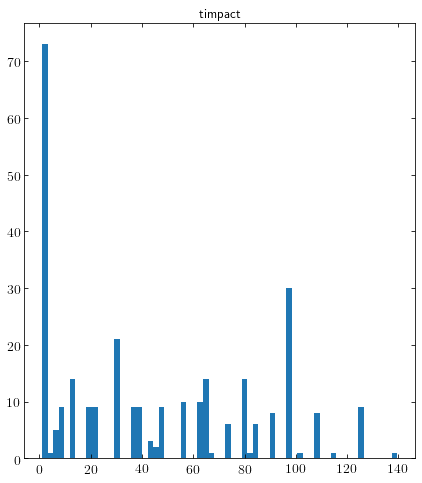

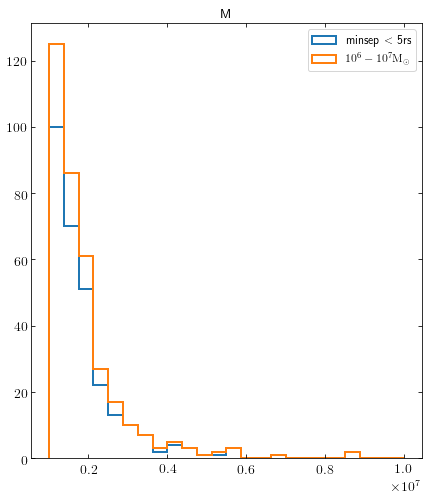

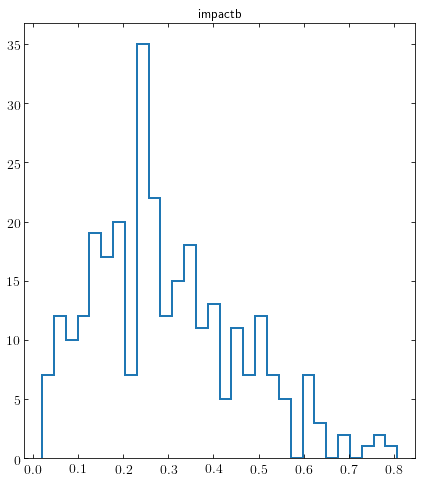

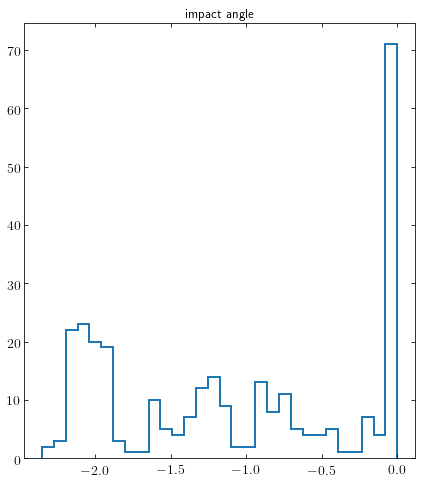

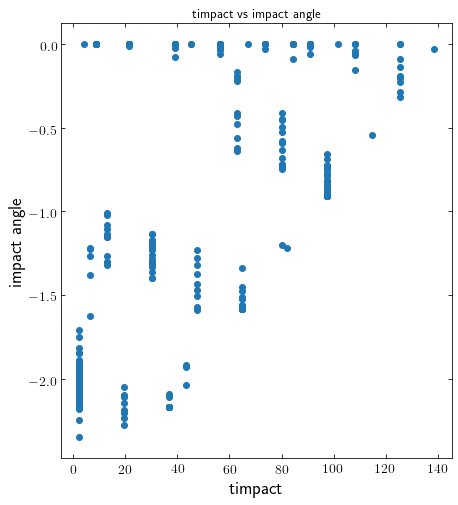

In [88]:
#a) histogram of timpact
#b) histogram of M (and maybe compare to the full histogram of M)
#c) histogram of impactb
#d) histogram of impact angle
#e) timpact vs. impact angle

plt.figure()
plt.title('timpact')
plt.hist(timpact_at_min,bins=tbin_edges)


mbins=np.linspace(10**6.,10**7.,25)
plt.figure()
plt.title('M')
plt.hist(np.array(M_mc)*bovy_conversion.mass_in_msol(vo,ro),bins=mbins,histtype='step',lw=2,label=r'minsep $<$ 5rs')
plt.hist(M,bins=mbins,histtype='step',lw=2,label=r'$10^{6} - 10^{7} \rm{M}_{\odot}$')
plt.legend(loc='upper right')




plt.figure()
plt.title('impactb')
plt.hist(impactb,bins=30,histtype='step',lw=2)





plt.figure()
plt.title('impact angle')
plt.hist(impact_angle,bins=30,histtype='step',lw=2)




plt.figure()
plt.title('timpact vs impact angle')
plt.scatter(timpact_at_min,impact_angle)
plt.xlabel('timpact')
plt.ylabel('impact angle')

plt.show()






In [ ]:
import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=v_mc,impact_angle=impact_angle,timpact=timpact_at_min,rs=rs_mc,GM=M_mc)

pepperfilename='Pal5_64impact_MC.pkl'

save_pickles(pepperfilename,sdf_smooth,sdf_pepper)

In [2]:
with open('Pal5_64impact_MC.pkl','rb') as savefile:
            sdf_smooth=pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

            

In [17]:
#compute dens in smaller intervals separately and then combine

apar=np.arange(0.,1.75,0.01)


densOmega= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar]).T

dens=densOmega[0]
Omega=densOmega[1]

dens_unp= [sdf_smooth._density_par(a) for a in apar]


In [11]:
apar0=np.arange(0.,0.51,0.01)
apar1=np.arange(0.51,1.01,0.01)
apar2=np.arange(1.01,1.5,0.01)
apar3=np.arange(1.51,1.76,0.01)


#dens_unp= [sdf_smooth._density_par(a) for a in apar]
import time
start = time.time()
densOmega_0= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar0]).T
end = time.time()
print (end - start)

start = time.time()
densOmega_1= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar1]).T
end = time.time()
print (end - start)

start = time.time()
densOmega_2= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar2]).T
end = time.time()
print (end - start)

start = time.time()
densOmega_3= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar3]).T
end = time.time()
print (end - start)

2.249913215637207
2.1360011100769043
2.229156494140625
1.1001701354980469


In [14]:
apar0=np.arange(0.,0.51,0.01)
apar1=np.arange(0.51,1.01,0.01)
apar2=np.arange(1.01,1.5,0.01)

print (apar0,apar1, apar2)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ] [0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64
 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78
 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92
 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ] [1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14
 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28
 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42
 1.43 1.44 1.45 1.46 1.47 1.48 1.49]


In [4]:
apar=np.concatenate((apar0,apar1,apar2,apar3))

dens=np.concatenate((densOmega_0[0],densOmega_1[0],densOmega_2[0],densOmega_3[0]))
Omega=np.concatenate((densOmega_0[1],densOmega_1[1],densOmega_2[1],densOmega_3[1]))

dens_unp= [sdf_smooth._density_par(a) for a in apar]

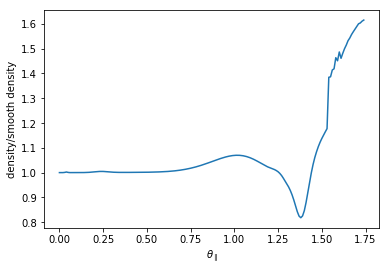

In [18]:
plt.figure()
plt.plot(apar,dens/dens_unp)

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
#plt.savefig('MC_106-107Msun_den_10MCs.pdf')
plt.show()

In [ ]:
#combine densOmega files

apars=np.empty(175)
dens=np.empty(175)
dens_unp=np.empty(175)
Omega=np.empty(175)

#'#apar   dens_unp   dens  omega_unp   omega'

for ii in range(175):
    dat=np.loadtxt('MC_densOmega/densOmega_{}.dat'.format(ii))
    apar[ii]=dat[0]
    dens_unp[ii]=dat[1]
    dens[ii]=dat[2]
    Omega[ii]=dat[4]
    
    
plt.figure()
plt.plot(apar,dens/dens_unp)

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
#plt.savefig('MC_106-107Msun_den_10MCs.pdf')
plt.show()

In [19]:
import pal5_util
from scipy import ndimage, signal, interpolate

#with open('Pal5_64impact_MC.pkl','rb') as savefile:
#            sdf_smooth=pickle.load(savefile,encoding='latin1')
#            sdf_pepper= pickle.load(savefile,encoding='latin1')


def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys



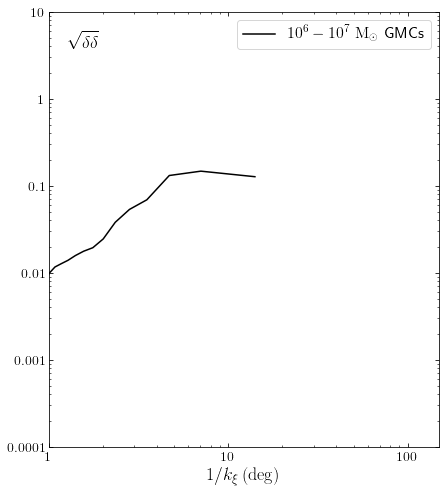

In [20]:
ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)

scaling = 'spectrum'
    
px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
py= py.real
px= 1./px
py= numpy.sqrt(py*(ll[-1]-ll[0]))
#return 180./px/numpy.pi, py, py_err #if apars


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

loglog(px,py,color='k',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ GMCs')

legend(loc='upper right',fontsize=16)
set_ranges_and_labels_dens()

